# PGF5005 — Exercício 5 · Hénon–Heiles — Itens **5.1** e **5.2**  
**Método de Euler simplético** + **Algoritmo de Hénon** (seção de Poincaré)

Hamiltoniana de Hénon–Heiles (adimensional), conforme o enunciado:  
$$
H(\mathbf{q},\mathbf{p})
= \frac{1}{2}\,(p_1^2+p_2^2+q_1^2+q_2^2) + q_1^2 q_2 - \frac{1}{3},q_2^3.
$$

Ela é separável na forma $H(\mathbf{q},\mathbf{p})=K(\mathbf{p})+U(\mathbf{q})$, com  
$$
K(\mathbf{p})=\tfrac{1}{2}(p_1^2+p_2^2),\qquad
U(\mathbf{q})=\tfrac{1}{2}(q_1^2+q_2^2)+q_1^2 q_2-\tfrac{1}{3}q_2^3.
$$

## 5.1 — Atualizações do **Euler simplético** (Euler–Cromer)

Para Hamiltonianas separáveis, as equações do Euler simplético em passo $\Delta t$ são:
$$
\boxed{
\begin{aligned}
\mathbf{q}^{\,n+1} &= \mathbf{q}^{\,n} + \Delta t\,\nabla_{\mathbf{p}}K(\mathbf{p}^{\,n}),\\
\mathbf{p}^{\,n+1} &= \mathbf{p}^{\,n} - \Delta t\,\nabla_{\mathbf{q}}U(\mathbf{q}^{\,n+1}).
\end{aligned}}
$$

No caso HH: $\nabla_{\mathbf{p}}K=(p_1,p_2)$ e  
$\nabla_{\mathbf{q}}U=\big(q_1+2q_1 q_2,\; q_2+q_1^2-q_2^2\big)$.  
Logo,
$$
\boxed{
\begin{aligned}
q_1^{n+1} &= q_1^{n} + \Delta t\,p_1^{n},\\
q_2^{n+1} &= q_2^{n} + \Delta t\,p_2^{n},\\[4pt]
p_1^{n+1} &= p_1^{n} - \Delta t\,(q_1^{n+1} + 2 q_1^{n+1} q_2^{n+1}),\\
p_2^{n+1} &= p_2^{n} - \Delta t\,(q_2^{n+1} + (q_1^{n+1})^2 - (q_2^{n+1})^2).
\end{aligned}}
$$

> **Ordem importa:** primeiro atualizamos $\mathbf{q}$ usando $\mathbf{p}^n$; depois, com $\mathbf{q}^{n+1}$ em mãos, atualizamos $\mathbf{p}$.


## 5.2 — Implementação: integrador simplético + algoritmo de Hénon (seção q1=0, p1≥0)

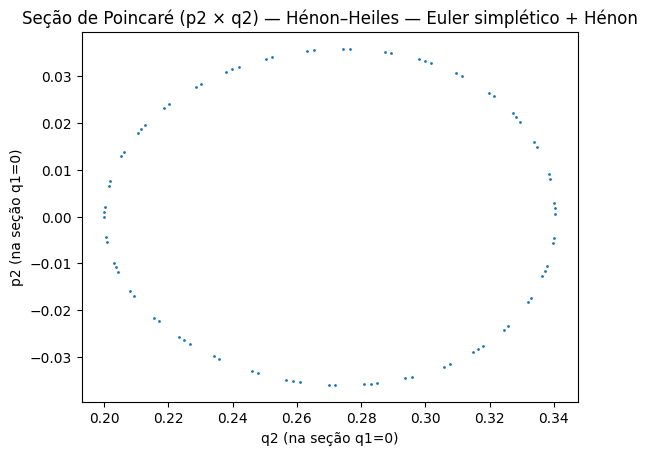

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def U_grad(q1, q2):
    dU_dq1 = q1 + 2.0*q1*q2
    dU_dq2 = q2 + q1*q1 - q2*q2
    return dU_dq1, dU_dq2

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1_next = q1 + dt*p1
    q2_next = q2 + dt*p2
    dU1, dU2 = U_grad(q1_next, q2_next)
    p1_next = p1 - dt*dU1
    p2_next = p2 - dt*dU2
    return q1_next, q2_next, p1_next, p2_next

def integrar_HH_symplectic(q1,q2,p1,p2, dt, T):
    n = int(np.ceil(T/dt))
    Q1=np.empty(n+1); Q2=np.empty(n+1); P1=np.empty(n+1); P2=np.empty(n+1); Tm=np.empty(n+1); E=np.empty(n+1)
    Q1[0]=q1; Q2[0]=q2; P1[0]=p1; P2[0]=p2; Tm[0]=0.0; E[0]=H(q1,q2,p1,p2)
    for k in range(n):
        q1,q2,p1,p2 = euler_symplectic_step(q1,q2,p1,p2, dt)
        Q1[k+1]=q1; Q2[k+1]=q2; P1[k+1]=p1; P2[k+1]=p2
        Tm[k+1]=(k+1)*dt; E[k+1]=H(q1,q2,p1,p2)
    return Tm,Q1,Q2,P1,P2,E

def henon_section_q1_zero(q1,q2,p1,p2, dt, T, max_points=2000):
    pts_q2 = []; pts_p2 = []
    Tm,Q1,Q2,P1,P2,E = integrar_HH_symplectic(q1,q2,p1,p2, dt, T)
    for k in range(len(Q1)-1):
        q1a, q1b = Q1[k], Q1[k+1]
        if q1a == 0.0:
            if P1[k] >= 0.0:
                pts_q2.append(Q2[k]); pts_p2.append(P2[k])
            continue
        if q1a*q1b < 0.0:
            fq1 = P1[k]  # dq1/dt
            if abs(fq1) < 1e-12:
                continue
            Dq1 = - q1a
            dU1, dU2 = U_grad(Q1[k], Q2[k])
            dq2_dq1 = P2[k]/fq1
            dp1_dq1 = - dU1 / fq1
            dp2_dq1 = - dU2 / fq1
            q2_star  = Q2[k] + Dq1 * dq2_dq1
            p1_star  = P1[k] + Dq1 * dp1_dq1
            p2_star  = P2[k] + Dq1 * dp2_dq1
            if p1_star >= 0.0:
                pts_q2.append(q2_star); pts_p2.append(p2_star)
    return np.array(pts_q2), np.array(pts_p2)

# Demonstração
dt = 1e-3
T  = 500.0
q1_0, q2_0 = 0.0, 0.2
p1_0, p2_0 = 0.4, 0.0

q2_pts, p2_pts = henon_section_q1_zero(q1_0, q2_0, p1_0, p2_0, dt, T, max_points=5000)

plt.figure()
plt.plot(q2_pts, p2_pts, '.', ms=2)
plt.xlabel('q2 (na seção q1=0)'); plt.ylabel('p2 (na seção q1=0)')
plt.title('Seção de Poincaré (p2 × q2) — Hénon–Heiles — Euler simplético + Hénon')
plt.show()


**Notas rápidas**
- O integrador temporal é **Euler simplético** (2ª ordem via mapa 1ª ordem, mas **simplicial** no sentido de preservação de área em cada par canônico).  
- O **algoritmo de Hénon** detecta um cruzamento $q_1=0$ e corrige por **um único passo** em $q_1$ para achar o ponto exato da seção (usando $\dot q_1$=$p_1$).  
- Mantemos apenas os pontos com $p_1^*\ge 0$, como especifica a seção.  
- Ajuste $\Delta t$, $T$ e condições iniciais conforme a energia/figuras desejadas para os próximos itens.
